In [33]:
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt

import hugs
from hugs.database.tables import Source, Synth
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord

In [29]:
from hugs.log import logger

In [2]:
import os
sys.path.append('../scripts')

In [3]:
import pandas as pd
from astropy.table import Table
default_synth_dir = '/tigress/jgreco/hsc-s18a/synths/global'

In [4]:
synth_fn = os.path.join(default_synth_dir, 'global-synth-cat.fits')
cat_fn = '../data/hugs-cat.csv'

In [122]:
synth_cat_all = Table.read(synth_fn)

In [5]:
db_fn = '/tigress/jgreco/hsc-s18a/synths/global/hsc-s18a-default-hugs/hsc-s18a-wide-synths.db'

In [6]:
engine = hugs.database.connect(db_fn)
session = hugs.database.Session()

In [115]:
def get_catalog(no_cuts=False):

    logger.info('connecting to hugs database')
    engine = hugs.database.connect(db_fn)
    session = hugs.database.Session()

    size_cut_low = 2.5
    size_cut_high = 100.0
    m, b = 0.7, 0.4

    color_line_lo =  lambda _x: m*_x - b
    color_line_hi =  lambda _x: m*_x + b
    gi = Source.mag_ap9_g - Source.mag_ap9_i
    gr = Source.mag_ap9_g - Source.mag_ap9_r

    if no_cuts:
        query = session.query(Source)
    else:
        logger.warn('applying cuts')
        query = session.query(Source)\
            .filter(Source.flux_radius_65_g > size_cut_low)\
            .filter(Source.flux_radius_65_g < size_cut_high)\
            .filter(gi > -0.1)\
            .filter(gi < 1.4)\
            .filter(color_line_lo(gi) < gr)\
            .filter(color_line_hi(gi) > gr)

    logger.info('converting query to pandas dataframe')
    cat = pd.read_sql(query.statement, engine)

    return cat

def match_synths(hugs_cat, synth_cat, min_sep=1.0*u.arcsec):

    if type(hugs_cat) != Table:
        hugs_cat = Table.from_pandas(hugs_cat)
    if type(synth_cat) != Table:
        synth_cat = Table.from_pandas(synth_cat)

    hugs_coord = SkyCoord(hugs_cat['ra'], hugs_cat['dec'], unit='deg')
    synth_coord = SkyCoord(synth_cat['ra'], synth_cat['dec'], unit='deg')

    logger.info('finding nearest neighbor within {:.1f}'.\
                format(min_sep))
    hugs_idx_1, sep_1, _ = synth_coord.match_to_catalog_sky(hugs_coord, 1)
    synth_mask_1 = sep_1 < min_sep
    synth_match = synth_cat[synth_mask_1]

    logger.info('finding second nearest neighbor within {:.1f}'.\
                format(min_sep))
    hugs_idx_2, sep_2, _ = synth_coord.match_to_catalog_sky(hugs_coord, 2)
    synth_mask_2 = sep_2 < min_sep

    synth_mask_12 = synth_mask_1 & synth_mask_2
    synth_match_12 = synth_cat[synth_mask_12]

    hugs_match_1 = hugs_cat[hugs_idx_1][synth_mask_12]
    hugs_match_2 = hugs_cat[hugs_idx_2][synth_mask_12]

    logger.info('keeping match with better radius measurement')
    diff_1 = np.abs(synth_match_12['r_e'] - hugs_match_1['flux_radius_50_i'])
    diff_2 = np.abs(synth_match_12['r_e'] - hugs_match_2['flux_radius_50_i'])
    switch_match = diff_1 > diff_2

    logger.warn('switching {} matches'.format(switch_match.sum()))
    mask_idx = np.argwhere(synth_mask_12)[~switch_match]
    synth_mask_12[mask_idx] = False

    hugs_idx_1[synth_mask_12] = hugs_idx_2[synth_mask_12]
    hugs_match = hugs_cat[hugs_idx_1[synth_mask_1]]

    return hugs_match, synth_match

In [218]:
len(hugs_match) / len(hugs_cat)

0.14984508354905005

In [9]:
query = session.query(Synth)
synth_ids = pd.read_sql(query.statement, engine)

synth_id_unique, synth_id_idx = np.unique(synth_ids['synth_id'].values, return_index=True)
synth_ids = synth_ids.iloc[synth_id_idx]

In [142]:
hugs_cat = get_catalog()

INFO: connecting to hugs database


/tigress/HSC/LSST/stack_tiger2-sumire.princeton.edu_20181028/stack/miniconda3-4.5.4-fcd27eb/Linux64/sqlalchemy/1.2.16/lib/python/SQLAlchemy-1.2.16-py3.6-linux-x86_64.egg/sqlalchemy/orm/scoping.py:107: SAWarning: At least one scoped session is already present.  configure() can not affect sessions that have already been created.
  "At least one scoped session is already present. "
/tigress/HSC/LSST/stack_tiger2-sumire.princeton.edu_20181028/python/miniconda3-4.5.4/envs/lsst-scipipe/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead


INFO: converting query to pandas dataframe


In [145]:
hugs_r_e = hugs_cat['flux_radius_60_g'] + hugs_cat['flux_radius_65_g']
hugs_r_e *= 0.5
hugs_cat['flux_radius_ave'] = hugs_r_e

hugs_mu_ave = hugs_cat['mag_auto_g']
hugs_mu_ave += 2.5 * np.log10(2*np.pi*hugs_cat['flux_radius_50_g']**2)
hugs_cat['hugs_mu_ave_g'] = hugs_mu_ave

In [44]:
mask_cols = ['mask_bright_object', 'mask_clean', 'mask_small', 
             'mask_no_data', 'mask_sat', 'mask_suspect']

In [201]:
print('{:.1f}% synths injected'.format(100*len(synth_id_unique)/len(synth_cat_all)))
synth_cat = synth_cat_all[synth_id_unique-1]

70.2% synths injected


In [202]:
masked = synth_ids['mask_bright_object'].values | synth_ids['mask_no_data'].values | synth_ids['mask_sat'].values
masked = masked.astype(bool)
masked_frac = masked.sum()/len(synth_cat)
print('{:.1f}% of synths masked'.format(100 * masked_frac))

12.6% of synths masked


In [215]:
synth_id_idx.size

226350

In [203]:
len(synth_cat), len(synth_cat_all)

(226350, 322361)

In [204]:
synth_cat = synth_cat[~masked]

In [205]:
len(synth_cat), len(synth_cat_all)

(197888, 322361)

In [206]:
hugs_match, synth_match = match_synths(hugs_cat, synth_cat)

INFO: finding nearest neighbor within 1.0 arcsec
INFO: finding second nearest neighbor within 1.0 arcsec
INFO: keeping match with better radius measurement


/tigress/HSC/LSST/stack_tiger2-sumire.princeton.edu_20181028/python/miniconda3-4.5.4/envs/lsst-scipipe/lib/python3.6/site-packages/ipykernel_launcher.py:65: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead


In [207]:
len(synth_match) / len(synth_cat)

0.7011744016817594

In [208]:
param_dict = dict(
    mu_e_ave_g = 'hugs_mu_ave_g',
    m_g = 'mag_auto_g',
    m_r = 'mag_auto_r',
    m_i = 'mag_auto_i',
    r_e = 'flux_radius_ave',
    ell='ellipticity'
    
)

labels = dict(
    m_g = r'$m_g$',
    m_r = r'$m_r$',
    m_i = r'$m_i$',
    mu_e_ave_g = r'$\bar{\mu}_\mathrm{eff}(g)\ \mathrm{\left[mag\ arcsec^{-2}\right]}$',
    mu_e_ave_r = r'$\bar{\mu}_\mathrm{eff}(g)\ \mathrm{\left[mag\ arcsec^{-2}\right]}$',
    mu_e_ave_i = r'$\bar{\mu}_\mathrm{eff}(g)\ \mathrm{\left[mag\ arcsec^{-2}\right]}$',
    r_e = r'$r_\mathrm{eff}$ [arcsec]',
    ell = 'Ellipticity'
)

In [209]:
def completeness_grid(injected, recovered, measured, x_par, y_par, annot_type='none', percent=True, mask_zeros=True,
                      cmap='Purples', label_fs=20, bins=None, dbin=[1,1], line_color='tab:red', 
                      x_bin_pad=[1, 3], y_bin_pad=[1, 3], frac_masked=0, return_hist_ax=False,
                      xlim=None, ylim=None):
    
    if bins is None:
        bins = [np.arange(np.floor(injected[x_par].min()) - x_bin_pad[0]*dbin[0], 
                          np.ceil(injected[x_par].max())+ x_bin_pad[1]*dbin[0], dbin[0]),
                np.arange(np.floor(injected[y_par].min())- y_bin_pad[0]*dbin[1], 
                          np.ceil(injected[y_par].max())+ y_bin_pad[1]*dbin[1], dbin[1])]        

    H_injected, _, _ = np.histogram2d(injected[x_par], injected[y_par], bins=bins)
    H_measured, _, _ = np.histogram2d(recovered[x_par], recovered[y_par], bins=bins)
    H_injected[H_injected==0] = 1e-8
    H_injected *= (1 - frac_masked)
    H_frac = H_measured/H_injected
    H_frac[H_frac<1e-5] = np.nan

    x_centers = 0.5 * (bins[0][1:] + bins[0][:-1]) - 0.5*dbin[0]
    y_centers = 0.5 * (bins[1][1:] + bins[1][:-1]) - 0.5*dbin[1]
    percent = 100.0 if percent else 1.0    
    
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_main = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
   
    fig = plt.figure(1, figsize=(9, 8))

    ax = plt.axes(rect_main)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    mask = (H_frac.T==0) if mask_zeros else None
    
    cax = ax.pcolormesh(x_centers, y_centers, percent * H_frac.T, cmap=cmap, vmin=0, vmax=percent)
    cbaxes = plt.axes([left, -0.015, width, 0.03]) 
    cbar = fig.colorbar(cax, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Detection Efficiency (\%)')
    #if percent==100.0:
    #    cbar.ax.set_xlim(0, 100)
    ax.set_xlabel(labels[x_par], fontsize=label_fs)
    ax.set_ylabel(ylabel=labels[y_par], fontsize=label_fs)
    ax.minorticks_on()
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)
    
    weights = np.ones_like(injected[x_par]) * (1 - frac_masked)
    
    axHistx.hist(injected[x_par], bins=x_centers, color='gray', alpha=0.5, 
                 label='Injected', weights=weights)
    
    axHistx.hist(recovered[x_par], bins=x_centers, color='k', alpha=0.5, label='Recovered')
    axHistx.hist(measured[param_dict[x_par]], bins=x_centers, color=line_color, label='Measured',
                 alpha=1, lw=3, histtype='step')

    axHisty.hist(injected[y_par], bins=y_centers, color='gray', alpha=0.5,
                 orientation='horizontal', weights=weights)
    axHisty.hist(recovered[y_par], bins=y_centers, color='k', alpha=0.5,
                 orientation='horizontal')
    axHisty.hist(measured[param_dict[y_par]], bins=y_centers, color=line_color, 
                 alpha=1, histtype='step', lw=3, orientation='horizontal')

    axHistx.set(xticklabels=[], xticks=ax.get_xticks(), xlim=ax.get_xlim())
    axHistx.set_ylabel('Number')
    axHisty.set(yticklabels=[], yticks=ax.get_yticks() ,ylim=ax.get_ylim())
    axHisty.set_xlabel('Number')
    axHistx.minorticks_on()
    axHisty.minorticks_on()
    axHistx.legend(loc=(1.03, 0.2), fontsize=17)

    return (fig, ax, axHistx, axHisty) if return_hist_ax else (fig, ax)


In [221]:
'adsfasdfdsf.csv'[:-4]

'adsfasdfdsf'

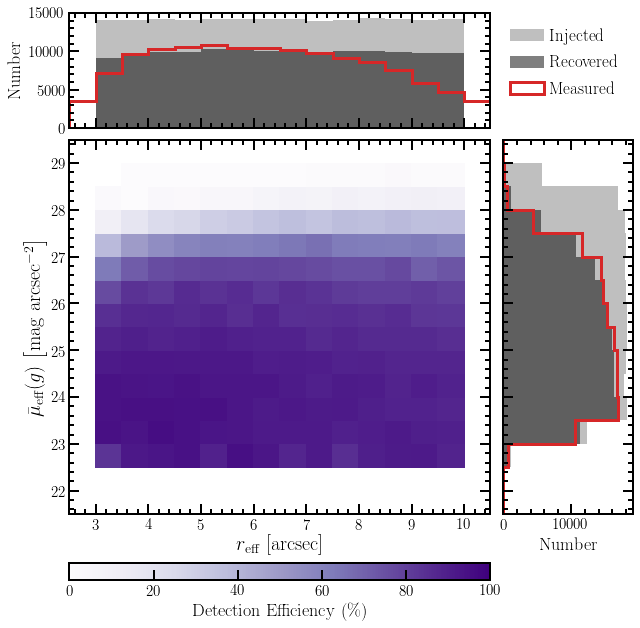

In [211]:
fig, ax = completeness_grid(synth_cat, synth_match, hugs_match, 'r_e', 'mu_e_ave_g', 
                            dbin=[0.5, 0.5], x_bin_pad=[1, 3]);

fig.savefig('../figs/completeness-mu-re.png', dpi=200)